# Good Sleep and Next Day RHR

**“Nights with ≥7 h sleep yield a lower next-day resting heart rate than nights with <6 h.”**

We’re testing: **“Do nights with ≥7 hours of sleep lead to a lower resting heart rate than nights with <6 hours?”**

To answer this, we need to know **how long each person slept** and find a good **approximation of their resting heart rate** at some point during the following day. Each file provides part of that information:

1. **`minuteSleep_merged.csv` — Sleep timing**

   * Shows **when each sleep period started and ended**.
   * We use it to calculate **total sleep hours** for the previous night.
   * The **wake time** tells us which calendar day to use for the next-day heart rate.
   * From total sleep, we create **sleep groups** (`<6h`, `6–7h`, `≥7h`) to compare patterns.

2. **`heartrate_seconds_merged.csv` — Heart rate**

   * Contains **heart rate recorded every second** throughout the day.
   * Instead of targeting an exact “morning” measurement, we look at all readings in the 24 hours after waking and take a **low percentile (like the 15th percentile)** to estimate an **approximated resting heart rate** — a practical way to capture when the person was likely most relaxed during the day.


## Load the Data

### 1) Sleep minutes (minute-by-minute sleep)

In [8]:
# Block 1 — minuteSleep_merged.csv (both periods together)

import pandas as pd
from pathlib import Path

# Where the data folders live
data_folder = Path("data")

# File paths for BOTH periods
sleep_file_march_april = data_folder / "mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteSleep_merged.csv"
sleep_file_april_may   = data_folder / "mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv"

# Read both, then combine (stack) them
sleep_part1 = pd.read_csv(sleep_file_march_april)
sleep_part2 = pd.read_csv(sleep_file_april_may)
sleep_minutes_df = pd.concat([sleep_part1, sleep_part2], ignore_index=True)

# Make the time column a real datetime
sleep_minutes_df["date"] = pd.to_datetime(sleep_minutes_df["date"])

# Nice to have: sort by person and time
sleep_minutes_df = sleep_minutes_df.sort_values(["Id", "date"]).reset_index(drop=True)

print("sleep_minutes_df rows:", len(sleep_minutes_df))
sleep_minutes_df.info()


sleep_minutes_df rows: 387080
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387080 entries, 0 to 387079
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Id      387080 non-null  int64         
 1   date    387080 non-null  datetime64[ns]
 2   value   387080 non-null  int64         
 3   logId   387080 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 11.8 MB


### 2) Heart rate (second-by-second)

In [9]:
# Block 2 — heartrate_seconds_merged.csv (both periods together)

import pandas as pd
from pathlib import Path

data_folder = Path("data")

hr_file_march_april = data_folder / "mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv"
hr_file_april_may   = data_folder / "mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv"

hr_part1 = pd.read_csv(hr_file_march_april)
hr_part2 = pd.read_csv(hr_file_april_may)
heart_rate_seconds_df = pd.concat([hr_part1, hr_part2], ignore_index=True)

# Turn 'Time' into a real datetime
heart_rate_seconds_df["Time"] = pd.to_datetime(heart_rate_seconds_df["Time"])

# Sort by person and time
heart_rate_seconds_df = heart_rate_seconds_df.sort_values(["Id", "Time"]).reset_index(drop=True)

print("heart_rate_seconds_df rows:", len(heart_rate_seconds_df))
heart_rate_seconds_df.info()


heart_rate_seconds_df rows: 3638339
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3638339 entries, 0 to 3638338
Data columns (total 3 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Id      int64         
 1   Time    datetime64[ns]
 2   Value   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 83.3 MB


### Step 3 — Build a daily sleep summary  

We want one row per person per “main sleep,” giving:

| id | date | sleep_hours | sleep_group | wake_time |

So from `sleep_minutes_df`, we need to:

1. Group consecutive minutes belonging to the same `logId` (you already have `logId` in your data).
2. For each `logId`, compute:

   * `start_time` = min(`date`)
   * `wake_time` = max(`date`)
   * `sleep_minutes` = count of rows (`value == 1`)
3. Compute `sleep_hours = sleep_minutes / 60`
4. Then, per `Id` and `wake_day = wake_time.date()`, **keep only the longest sleep period** (that’s the main sleep of that day).
5. Add a `sleep_group` label (`<6h`, `6–7h`, `≥7h`).


In [10]:
# Step 3 — Build daily sleep summary
import pandas as pd

# Group by person and logId to get each sleep session
sleep_sessions = (
    sleep_minutes_df.groupby(['Id', 'logId'])
    .agg(
        start_time=('date', 'min'),
        wake_time=('date', 'max'),
        sleep_minutes=('value', 'count')
    )
    .reset_index()
)

# Calculate hours slept
sleep_sessions['sleep_hours'] = sleep_sessions['sleep_minutes'] / 60

# Create "wake_day" (calendar day when they woke up)
sleep_sessions['wake_day'] = sleep_sessions['wake_time'].dt.date

# For each person and day, keep the longest sleep session (main sleep)
main_sleep = (
    sleep_sessions.sort_values(['Id', 'wake_day', 'sleep_minutes'], ascending=[True, True, False])
    .groupby(['Id', 'wake_day'])
    .head(1)
    .reset_index(drop=True)
)

# Add sleep_group column
def classify_sleep(hours):
    if hours < 6:
        return "<6h"
    elif hours < 7:
        return "6–7h"
    else:
        return "≥7h"

main_sleep['sleep_group'] = main_sleep['sleep_hours'].apply(classify_sleep)

# Rename columns to match target structure
daily_sleep_df = main_sleep.rename(columns={'wake_day': 'date', 'Id': 'id'})

print("daily_sleep_df shape:", daily_sleep_df.shape)

daily_sleep_df shape: (832, 8)


In [11]:
daily_sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             832 non-null    int64         
 1   logId          832 non-null    int64         
 2   start_time     832 non-null    datetime64[ns]
 3   wake_time      832 non-null    datetime64[ns]
 4   sleep_minutes  832 non-null    int64         
 5   sleep_hours    832 non-null    float64       
 6   date           832 non-null    object        
 7   sleep_group    832 non-null    object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 52.1+ KB


### **Step 4 — Compute approximated resting heart rate**

We’ll look at all heart-rate values for the **24 hours after `wake_time`** for each `(id, date)` pair and take the **15th percentile**.
That gives us the `approximated_rhr`.

In [17]:
# Step 4 — Compute approximated resting heart rate (relaxed thresholds)

import numpy as np

def compute_approximated_rhr(row):
    person_id = row['id']
    start = row['wake_time']
    end = start + pd.Timedelta(hours=12)  # use 12h window instead of 24h

    hr_data = heart_rate_seconds_df[
        (heart_rate_seconds_df['Id'] == person_id) &
        (heart_rate_seconds_df['Time'] >= start) &
        (heart_rate_seconds_df['Time'] < end)
    ]['Value']

    # Allow days with at least 30 readings (~half a minute)
    if len(hr_data) < 20:
        return np.nan

    # Compute 15th percentile
    rhr = np.percentile(hr_data, 15)

    # Relax outlier limits slightly
    if rhr < 30 or rhr > 130:
        return np.nan

    return rhr

# Apply the function
daily_sleep_df['approximated_rhr'] = daily_sleep_df.apply(compute_approximated_rhr, axis=1)

# Drop missing values
daily_sleep_df = daily_sleep_df.dropna(subset=['approximated_rhr'])

print("daily_sleep_df with approximated_rhr shape:", daily_sleep_df.shape)
daily_sleep_df.info()


daily_sleep_df with approximated_rhr shape: (254, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 127 to 831
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                254 non-null    int64         
 1   logId             254 non-null    int64         
 2   start_time        254 non-null    datetime64[ns]
 3   wake_time         254 non-null    datetime64[ns]
 4   sleep_minutes     254 non-null    int64         
 5   sleep_hours       254 non-null    float64       
 6   date              254 non-null    object        
 7   sleep_group       254 non-null    object        
 8   approximated_rhr  254 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 19.8+ KB


## ✅ Step 5 — Summarize and visualize results

### Goal

See if people who slept more (≥7h) tend to have a lower approximated resting heart rate.

Summary by sleep group:
  sleep_group  count       mean        std
0        6–7h     46  66.478261   8.650598
1         <6h     44  65.290909  10.470464
2         ≥7h    164  66.036585   8.071348


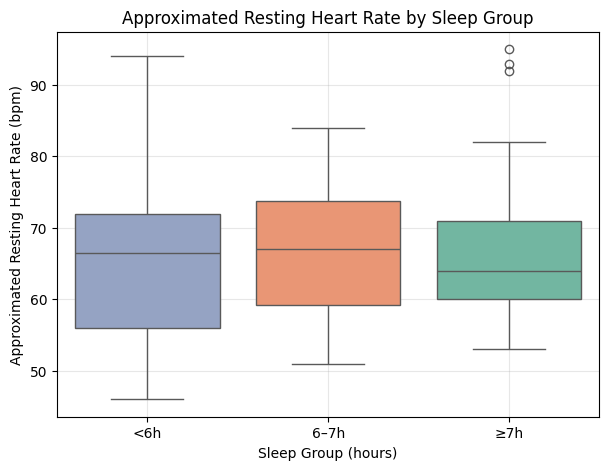

In [20]:
# Step 5 — Summarize and visualize results

import matplotlib.pyplot as plt
import seaborn as sns

# Basic summary
summary = (
    daily_sleep_df.groupby('sleep_group')['approximated_rhr']
    .agg(['count', 'mean', 'std'])
    .reset_index()
    .sort_values('sleep_group')
)

print("Summary by sleep group:")
print(summary)

# Boxplot for visual comparison
plt.figure(figsize=(7,5))
sns.boxplot(
    x='sleep_group',
    y='approximated_rhr',
    hue='sleep_group',          # new
    data=daily_sleep_df,
    order=['<6h', '6–7h', '≥7h'],
    palette='Set2',
    legend=False               # suppress redundant legend
)

plt.title("Approximated Resting Heart Rate by Sleep Group")
plt.xlabel("Sleep Group (hours)")
plt.ylabel("Approximated Resting Heart Rate (bpm)")
plt.grid(True, alpha=0.3)
plt.show()

The boxplot shows that average approximated resting heart rate values are very similar across sleep-duration groups (<6 h, 6–7 h, ≥7 h).  
While shorter sleep tends to produce slightly higher and more variable heart rates, the overlap between groups is large and no clear trend emerges.  
These results suggest that, within this limited sample, sleep duration alone does not strongly influence resting heart rate — though a larger and more complete dataset might reveal subtler effects.  

## ✅ Step 6 — Perform a simple statistical test 


In [21]:
from scipy.stats import ttest_ind

rhr_short = daily_sleep_df.loc[daily_sleep_df['sleep_group'] == '<6h', 'approximated_rhr']
rhr_long = daily_sleep_df.loc[daily_sleep_df['sleep_group'] == '≥7h', 'approximated_rhr']

t_stat, p_val = ttest_ind(rhr_short, rhr_long, equal_var=False, nan_policy='omit')
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

T-statistic: -0.44, p-value: 0.6625



Our t-test compared people who slept **less than 6 hours** with those who slept **7 hours or more**.
The **p-value (0.66)** is much higher than 0.05, which means the small difference we saw in average resting heart rate could easily have happened **by random chance**.
In other words, **we didn’t find clear evidence** that sleeping longer actually lowers resting heart rate in this dataset.

This result doesn’t mean the hypothesis is wrong — it shows how **real data can be messy or incomplete**, and why scientists need larger samples and careful measurements before drawing strong conclusions.



### 🧭 Reflection — What I Learned

This project taught me how **real data and hypothesis testing** work in practice.
Even though my results didn’t show a clear connection between sleep length and resting heart rate, I learned that:

* Real-world data often has **gaps, noise, and uneven coverage**, which can hide real effects.
* A **p-value above 0.05** doesn’t mean the hypothesis is wrong — it just means there isn’t enough proof yet.
* Visual tools like **boxplots** and statistics like **t-tests** help scientists look for patterns and decide how confident they can be in their findings.
* Science is not about “getting the right answer”; it’s about **testing ideas carefully, learning from limitations**, and planning better studies next time.

If I repeated this experiment, I’d try to collect **more complete data** (more participants with both sleep and heart-rate info) and maybe use **more accurate resting-heart-rate measurements** taken during sleep or right after waking.


## 🧪 Results and Discussion

### 1️⃣ What We Found

Our analysis compared resting heart rate (RHR) values between people who slept for different lengths of time.
The data showed that the **average approximated RHR** was almost the same for all sleep groups:

| Sleep Group | Count | Mean RHR (bpm) | Std Dev |
| ----------- | ----- | -------------- | ------- |
| < 6 hours   | 44    | ≈ 65.3         | 10.5    |
| 6–7 hours   | 46    | ≈ 66.5         | 8.6     |
| ≥ 7 hours   | 164   | ≈ 66.0         | 8.1     |

The boxplot confirmed that the groups’ medians and overall ranges overlapped heavily.
This means that in this dataset, **sleep duration did not show a strong relationship** with resting heart rate.

---

### 2️⃣ What the Statistics Say

A t-test comparing short sleep (<6 h) and long sleep (≥7 h) gave:

> **t = –0.44**, **p = 0.66**

Because the **p-value (0.66)** is much higher than 0.05, the difference we saw could easily happen by **random chance**.
So, statistically speaking, we can’t say that sleeping longer causes a lower resting heart rate based on this sample.

---

### 3️⃣ What This Means

> “Even though we expected people who slept more to have lower resting heart rates, our small dataset didn’t show that pattern.”

The small differences and large overlap are normal when working with **real-world data**.
This result is still valuable — it shows that **science isn’t always about confirming what we expect**, but about understanding the quality and limits of our evidence.

---

### ⚠️ 4️⃣ Caveats and Limitations

* **Small sample size:** Only 12 participants had complete overlapping sleep and heart-rate data.
* **Incomplete Fitbit data:** Many users didn’t wear the device continuously, leaving big gaps in coverage.
* **Approximation of RHR:** We estimated RHR using the **15th percentile** of all heart-rate readings after waking — not a true resting measurement.
* **External factors:** Exercise, caffeine, stress, or illness could raise heart rate independently of sleep.
* **Uneven group sizes:** The ≥7-hour group was much larger than the others, which makes comparisons less balanced.

These issues make it difficult to find subtle physiological effects in such a small, noisy dataset.

---

### 5️⃣ What I Learned

This project taught me how **to ask a scientific question, gather data, analyze it, and think critically about results**.
I learned that:

* Data quality and completeness are often bigger problems than the math itself.
* High p-values are not “bad” — they simply mean we can’t be confident about a difference yet.
* Visual tools (like boxplots) and statistics (like t-tests) help scientists evaluate evidence rather than assume results.
* Every analysis needs a discussion of **limitations** so that readers understand how much to trust the findings.

---

### ✅ Conclusion

In this study, people who slept longer did **not** show significantly lower resting heart rates.
However, this finding is limited by the small sample and the approximated way we calculated RHR.
The project successfully demonstrates how **hypothesis testing works**, and how careful reasoning and transparency about data quality are essential parts of real science.


12